# Churn prediction for an energy company 🔌💡
## Part 3 - Model Building
### Importing packages, models and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SAS models
from sasviya.ml.linear_model import LogisticRegression as SASLogisticRegression
from sasviya.ml.tree import DecisionTreeClassifier as SASDecisionTreeClassifier
from sasviya.ml.tree import ForestClassifier as SASForestClassifier
from sasviya.ml.tree import GradientBoostingClassifier as SASGradientBoostingClassifier

# scikit-learn classes and models
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as SKGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from imblearn.under_sampling import RandomUnderSampler

repo_path = "/workspaces/myfolder/energy-churn-prediction"

merged_df = pd.read_csv(f"{repo_path}/data/merged_data.csv")
merged_df.head(5)

,id,channel_sales,forecast_meter_rent_12m,has_gas,origin_up,churn,price_off_peak_var_min,price_off_peak_var_max,nb_prod_act_cat,num_years_antig_cat,...,is_zero_cons_last_month,cons_last_month_log,net_margin_log,price_off_peak_fix_max_diff_log,forecast_cons_12m_log,price_off_peak_var_std_log,pow_max_log,margin_net_pow_ele_log,product_modified,days_to_end
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,1.78,Yes,Campaign 1,Yes,0.117479,0.146033,2,3 or less,...,1,8.618564,6.522078,1.512496,0.000000,0.007799,3.798810,3.274878,1,167
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,16.27,No,Campaign 2,No,0.146033,0.151367,1,6,...,1,8.618564,2.990217,0.163631,5.252012,0.002210,2.694627,2.855320,0,243
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,38.72,No,Campaign 2,No,0.167798,0.172468,1,6,...,1,8.618564,2.028148,0.163630,3.891004,0.002393,2.698404,3.387774,0,107
3,bba03439a292a1e166f80264c16191cb,Channel 2,19.83,No,Campaign 2,No,0.148586,0.153133,1,6,...,1,8.618564,3.275634,0.163630,5.484963,0.002314,2.653242,3.441059,0,90
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,131.73,No,Campaign 2,No,0.119906,0.128067,1,6,...,0,6.267201,3.891412,0.150930,6.101999,0.003840,3.034953,3.826683,0,67


In [2]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 41 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   14447 non-null  object 
 1   channel_sales                        14447 non-null  object 
 2   forecast_meter_rent_12m              14447 non-null  float64
 3   has_gas                              14447 non-null  object 
 4   origin_up                            14447 non-null  object 
 5   churn                                14447 non-null  object 
 6   price_off_peak_var_min               14447 non-null  float64
 7   price_off_peak_var_max               14447 non-null  float64
 8   nb_prod_act_cat                      14447 non-null  object 
 9   num_years_antig_cat                  14447 non-null  object 
 10  forecast_discount_energy_cat         14447 non-null  object 
 11  price_off_peak_fix_min_cat  

## Preparing the data

In [3]:
target = 'churn'

X = merged_df.drop(['id', target], axis=1)
y = merged_df[target]

for index in y.value_counts().index:
    print(f"- Number of rows with Churn='{index}': {y.value_counts()[index]} ({y.value_counts(normalize=True)[index]*100:.2f} %)")

- Number of rows with Churn='No': 13052 (90.34 %)
- Number of rows with Churn='Yes': 1395 (9.66 %)


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [5]:
y_train.value_counts(), y_test.value_counts()

(churn
 No     10441
 Yes     1116
 Name: count, dtype: int64,
 churn
 No     2611
 Yes     279
 Name: count, dtype: int64)

In [6]:
cat_cols = X.select_dtypes(exclude='number').columns
numeric_cols = X.select_dtypes(include='number').columns

cat_cols_with_two_values = [col for col in cat_cols if X[col].nunique() == 2]
cat_cols_with_more_values = [col for col in cat_cols if X[col].nunique() > 2]

for col in cat_cols_with_two_values:
    print(X[col].value_counts())
    print('---------------------------')

has_gas
No     11819
Yes     2628
Name: count, dtype: int64
---------------------------
forecast_discount_energy_cat
0     13940
>0      507
Name: count, dtype: int64
---------------------------


## Logistic Regressions

In [7]:
sas_lr = SASLogisticRegression()
sklearn_lr = SKLogisticRegression(solver='liblinear')

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes'], ['0','>0']]), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

# Define the pipeline
sklearn_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_lr)
])

#sas_lr.fit(X_train, y_train, nominals=cat_cols)
#lr_pipeline.fit(X_train, y_train)

In [10]:
def train_and_evaluate_model(X, y, target_variable, model, model_type, library, numeric_cols=None, k=5, resampling=True, sampling_strategy=0.25, imbalance=False, nominals=None):
    """
    Train and test a model using k-fold cross-validation with optional random undersampling.

    Parameters:
    data (pandas.DataFrame): The input dataset.
    target_variable (str): The name of the target variable.
    model: The model to be trained and tested (e.g., LogisticRegression, RandomForest, etc.).
    k (int): The number of splits for cross-validation.
    resampling (bool): Whether to apply random undersampling (default: True).
    imbalance (bool): Whether to use class-weighting for imbalanced classes (default: False).
    threshold (float): The threshold for classification probability to define positive class (optional).

    Returns:
    pandas.DataFrame: A DataFrame containing the AUC scores for train and test sets.
    """
    
    # Separate features and target variable
    #X = data.drop(target_variable, axis=1).values
    #y = data[target_variable].values
    #X = data.drop(target_variable, axis=1)
    #y = data[target_variable]

    # Stratified k-fold cross-validation setup
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=12345)

    auc_train_scores = []
    auc_val_scores = []

    # Initialize RandomUnderSampler if needed
    if resampling:
        rus = RandomUnderSampler(random_state=12345, sampling_strategy=sampling_strategy)

    for train_index, val_index in kf.split(X, y):
        #X_train, X_test = X[train_index], X[test_index]
        #y_train, y_test = y[train_index], y[test_index]
        X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if numeric_cols is not None:
            ss = StandardScaler()
            X_train = X_train.apply(lambda x: x.astype('float64') if x.dtype == 'int64' else x)
            X_val = X_val.apply(lambda x: x.astype('float64') if x.dtype == 'int64' else x)
            X_train.loc[:,numeric_cols] = ss.fit_transform(X_train.loc[:,numeric_cols])
            X_val.loc[:,numeric_cols] = ss.transform(X_val.loc[:,numeric_cols])
        
        # Apply random undersampling
        if resampling:
            X_train, y_train = rus.fit_resample(X_train, y_train)

        # Apply class weighting if imbalance is True
        if imbalance:
            model.class_weight = 'balanced'
        
        # Train the model
        if nominals is not None:
            model.fit(X_train, y_train, nominals=nominals)
        else:
            model.fit(X_train, y_train)
            
        # Predict probabilities (used for AUC calculation)
        if type(model.predict_proba(X_train))==pd.core.frame.DataFrame:
            y_proba_train = model.predict_proba(X_train).iloc[:, 1]
            y_proba_val = model.predict_proba(X_val).iloc[:, 1]
        else:
            y_proba_train = model.predict_proba(X_train)[:, 1]
            y_proba_val = model.predict_proba(X_val)[:, 1]

        # Compute AUC scores for train and test sets
        auc_train_scores.append(roc_auc_score(y_train, y_proba_train))
        auc_val_scores.append(roc_auc_score(y_val, y_proba_val))

    # Collect the results
    scores = {
        'auc_train': np.array(auc_train_scores),
        'auc_val': np.array(auc_val_scores)
    }

    # Create a summary dataframe with the results
    model_metrics = pd.DataFrame(
        [{
            'Model Type': model_type,
            'library': library,
            'auc_train': round(np.mean(scores['auc_train']),3),
            'auc_val': round(np.mean(scores['auc_val']),3),
            'auc_train_std': round(np.std(scores['auc_train']),3),
            'auc_val_std': round(np.std(scores['auc_val']),3)
        }]
    )

    return model_metrics

In [11]:
standardizer = ColumnTransformer(
    transformers=[
        ('standardizer', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

sklearn_lr_model_metrics = train_and_evaluate_model(X_train, y_train, target, sklearn_lr_pipeline, 'Logistic Regression', 'scikit-learn', k=5, sampling_strategy=0.25, numeric_cols=numeric_cols)
sas_lr_model_metrics = train_and_evaluate_model(X_train, y_train, target, sas_lr, 'Logistic Regression', 'SAS', k=5, sampling_strategy=0.25, numeric_cols=numeric_cols, nominals=cat_cols)

metrics_df = sklearn_lr_model_metrics
metrics_df = pd.concat([metrics_df, sas_lr_model_metrics], ignore_index=True)
metrics_df

,Model Type,library,auc_train,auc_val,auc_train_std,auc_val_std
0,Logistic Regression,scikit-learn,0.659,0.638,0.002,0.015
1,Logistic Regression,SAS,0.659,0.638,0.002,0.016


## Decision Trees

In [12]:
sas_dtree = SASDecisionTreeClassifier()
sklearn_dtree = SKDecisionTreeClassifier()

dtree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_dtree)
])

#sas_dtree.fit(X_train, y_train, nominals=cat_cols)
#dtree_pipeline.fit(X_train, y_train)

In [13]:
sklearn_dtree_metrics = train_and_evaluate_model(X_train, y_train, target, dtree_pipeline, 'Decision Tree', 'scikit-learn', k=5, sampling_strategy=0.25)
sas_dtree_metrics = train_and_evaluate_model(X_train, y_train, target, sas_dtree, 'Decision Tree', 'SAS', k=5, sampling_strategy=0.25, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_dtree_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_dtree_metrics], ignore_index=True)
metrics_df

,Model Type,library,auc_train,auc_val,auc_train_std,auc_val_std
0,Logistic Regression,scikit-learn,0.659,0.638,0.002,0.015
1,Logistic Regression,SAS,0.659,0.638,0.002,0.016
2,Decision Tree,scikit-learn,1.000,0.566,0.000,0.005
3,Decision Tree,SAS,0.644,0.591,0.013,0.020


## Random Forests

In [14]:
# SAS Random Forest Model
sas_rf = SASForestClassifier()
sklearn_rf = SKRandomForestClassifier()

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_rf)
])

#sas_rf.fit(X_train, y_train, nominals=cat_cols)
#rf_pipeline.fit(X_train, y_train)

In [15]:
sklearn_rf_metrics = train_and_evaluate_model(X_train, y_train, target, rf_pipeline, 'Random Forest', 'scikit-learn', k=5, sampling_strategy=0.25)
sas_rf_metrics = train_and_evaluate_model(X_train, y_train, target, sas_rf, 'Random Forest', 'SAS', k=5, sampling_strategy=0.25, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_rf_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_rf_metrics], ignore_index=True)
metrics_df

,Model Type,library,auc_train,auc_val,auc_train_std,auc_val_std
0,Logistic Regression,scikit-learn,0.659,0.638,0.002,0.015
1,Logistic Regression,SAS,0.659,0.638,0.002,0.016
2,Decision Tree,scikit-learn,1.000,0.566,0.000,0.005
3,Decision Tree,SAS,0.644,0.591,0.013,0.020
4,Random Forest,scikit-learn,1.000,0.671,0.000,0.021
5,Random Forest,SAS,0.796,0.628,0.013,0.007


## Gradient Boosting

In [16]:
sas_gb = SASGradientBoostingClassifier()
sklearn_gb = SKGradientBoostingClassifier()

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_gb)
])

#sas_gb.fit(X_train, y_train, nominals=cat_cols)
#gb_pipeline.fit(X_train, y_train)

In [17]:
sklearn_gb_metrics = train_and_evaluate_model(X_train, y_train, target, gb_pipeline, 'Gradient Boosting', 'scikit-learn', k=5, sampling_strategy=0.25)
sas_gb_metrics = train_and_evaluate_model(X_train, y_train, target, sas_gb, 'Gradient Boosting', 'SAS', k=5, sampling_strategy=0.25, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_gb_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_gb_metrics], ignore_index=True)
metrics_df

,Model Type,library,auc_train,auc_val,auc_train_std,auc_val_std
0,Logistic Regression,scikit-learn,0.659,0.638,0.002,0.015
1,Logistic Regression,SAS,0.659,0.638,0.002,0.016
2,Decision Tree,scikit-learn,1.000,0.566,0.000,0.005
3,Decision Tree,SAS,0.644,0.591,0.013,0.020
4,Random Forest,scikit-learn,1.000,0.671,0.000,0.021
5,Random Forest,SAS,0.796,0.628,0.013,0.007
6,Gradient Boosting,scikit-learn,0.821,0.672,0.002,0.017
7,Gradient Boosting,SAS,0.886,0.674,0.003,0.022


## Model Selection

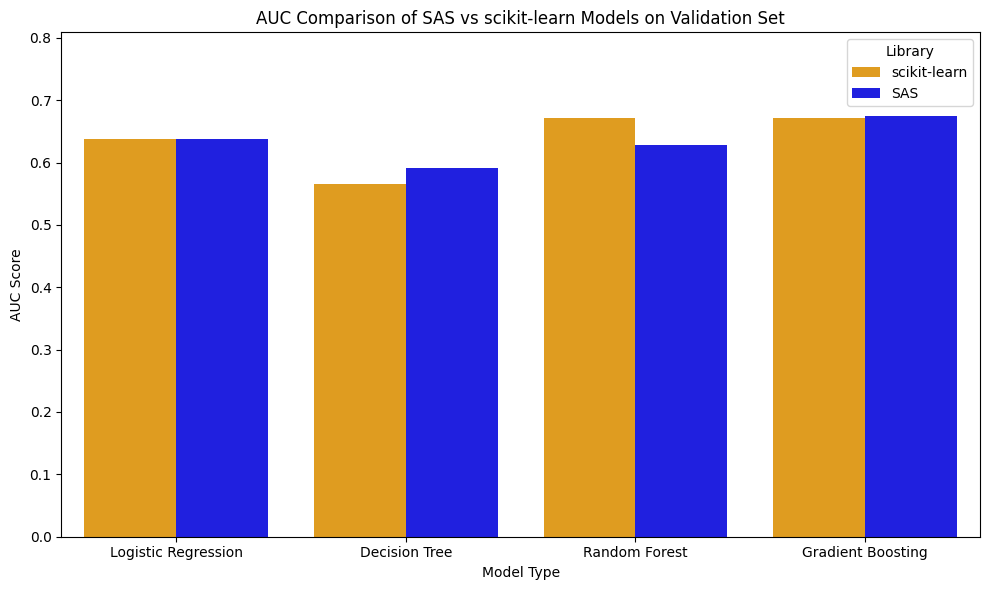

In [24]:
# models = {
#     "Logistic Regression": {
#         "SAS": sas_lr,
#         "scikit-learn": lr_pipeline
#     },
#     "Decision Tree": {
#         "SAS": sas_dtree,
#         "scikit-learn": dtree_pipeline
#     },
#     "Random Forest": {
#         "SAS": sas_rf,
#         "scikit-learn": rf_pipeline
#     },
#     "Gradient Boosting": {
#         "SAS": sas_gb,
#         "scikit-learn": gb_pipeline
#     }
# }

# Compute AUC for all models
# results = []
# for model_name, libraries in models.items():
#     for library_name, model in libraries.items():
#         if library_name == 'SAS':
#             y_pred_proba = model.predict_proba(X_test).iloc[:, 1]
#         else:
#             y_pred_proba = model.predict_proba(X_test)[:, 1]
#         auc = roc_auc_score(y_test, y_pred_proba)
#         results.append({
#             "Model Type": model_name,
#             "Library": library_name,
#             "AUC": auc
#         })

# Convert results to a DataFrame
# results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))
colors = {"SAS": "blue", "scikit-learn": "orange"}
ax = sns.barplot(
    data=metrics_df, 
    x="Model Type", 
    y="auc_val", 
    hue="library", 
    palette=colors
)
plt.title("AUC Comparison of SAS vs scikit-learn Models on Validation Set")
plt.ylabel("AUC Score")
plt.xlabel("Model Type")
plt.legend(title="Library")
ax.set_ylim(0, metrics_df["auc_val"].max() * 1.2)
plt.tight_layout()
plt.show()

In [27]:
best_model = sas_gb
best_model.fit(X_train, y_train, nominals=cat_cols)

GradientBoostingClassifier()

## Cutoff optimization

The SAS Gradient Boosting model is the one performing better on test data. Therefore, this is the model we'll choose for identifying churners among our customer base to take action and try to keep them. Let's assume that to prevent a client from churning, PowerCo issues a 10% discount on their electricity price. We also assume that this definitively deters the client from churning.

Even though PowerCo doesn't want either to lose a client and is ready to give it a discount, they don't want to hand out free discounts and offer it also to customers who would stay anyway. Keeping that in mind, let's now identify the churn probability threshold that enables us to optimize the overall profit for PowerCo.

To this aim, we can compute for different probability thresholds the profit function as:
$$
\text{Profit}(p)=\text{Gains}-\text{Loss}+\text{Prevented Loss}-\text{Discount Loss}
$$
where:
- **Gains** is the sum of all margins, contained in net_margin_ele variable
- **Loss** is the sum of all margins of actual churners
- **Prevented Loss** is the sum of all margins of actual churners that are correctly predicted as churners by the model with threshold $p$
- **Discount Loss** is the sum of discounts given to all predicted churners (whether correctly or incorrectly predicted). In our example, we might assume that the discount is operated on the net margin (that is only a component of the total tariff), to make computations easier, but it should be actually properly defined what a 10% tariff discount means.

Then, choose the threshold $p^*$ leading to the highest profit, given by $Profit(p^*)$.
We can compare this situation with what would’ve happened if we didn’t do anything:
$$
\text{Profit}=\text{Gains}-\text{Loss}
$$
to compute the financial impact of our model (percent improvement in profit).

The discount is an hyperparameter of the model, in a sense, that can be tuned based on how much increase in profit you want to achieve and/or on the average current competitor price for the customer we are considering. For example, based on postal code and number of kWh consumed, the average competitor price can change, and then considering the percent difference between LichtBlick tariff and average tariff can help us choose the discount needed in order for it to be effective.

In [43]:
import matplotlib.pyplot as plt

def test_model(y, preds, margins, event_value='Yes', discount_rate=0.1, discount_efficiency=0.8):
    """Test a model by calculating the margin saved when applying a discount,
    taking into account discounts wrongly applied to non-churning clients. """
    def find_best_p(preds, discount, discount_efficiency, granularity=200):
        """Optimization function to find the best probability cutoff"""
        probas = np.linspace(0, 1, granularity)
        output_margins = np.zeros(len(probas))
        actual_churners = (y == event_value)

        gains = np.sum(margins)*1000
        loss = sum(margins[actual_churners])*1000

        for i, p in enumerate(probas):
            predicted_churners = preds>=p
            prevented_loss = sum(margins[predicted_churners & actual_churners])*1000*discount_efficiency
            # To make calculations easier, we assume that the discount
            # is operated on the net margin. It could actually be a bit more.
            discount_loss = sum(margins[predicted_churners])*discount*1000
            output_margins[i] = gains - loss + prevented_loss - discount_loss

        best_profit = max(output_margins)
        best_p_index = list(output_margins).index(best_profit)
        best_p = probas[best_p_index]
        worst_profit = gains - loss
        return probas, output_margins, best_p, best_profit, worst_profit
    
    # Find optimal cutoff and margins
    probas, output_margins, best_p, best_profit, worst_profit = find_best_p(preds, discount_rate, discount_efficiency, 200)
    
    # Calculate additional metrics
    num_customers_best_p = np.sum(preds >= best_p)
    total_customers = len(y)
    
    print('Above a', round(best_p, 4), 'predicted probability of churn, we should apply the', discount_rate * 100, '% discount to the client.')
    print("By doing so, PowerCo would make {} € more in annual profit ({}% more than without the model).".format(
        round(best_profit - worst_profit, 2), 
        round(100 * (best_profit - worst_profit) / worst_profit, 2)))
    print(f"""{num_customers_best_p} out of {total_customers} customers ({round(100 * num_customers_best_p / total_customers, 2)}%) """
          f"""would receive the discount and we are assuming a {discount_efficiency*100} % efficiency of the retention campaign.""")
    
    plt.plot(probas, output_margins)
    plt.xlabel("Probability cutoff")
    plt.ylabel("Annual Profit")
    plt.axvline(x=best_p, color='red')
    plt.show()

Regarding the annual profit, we will use the `margin_net_pow_ele_log` variable. However, we need to retrieve the original values, which can be obtained by applying the inverse transformation of $log(1+x)$, i.e. $x=exp(y)-1$.

Gradient Boosting model
Above a 0.1156 predicted probability of churn, we should apply the 10.0 % discount to the client.
By doing so, PowerCo would make 2139202.0 € more in annual profit (3.46% more than without the model).
718 out of 2890 customers (24.84%) would receive the discount and we are assuming a 80.0 % efficiency of the retention campaign.


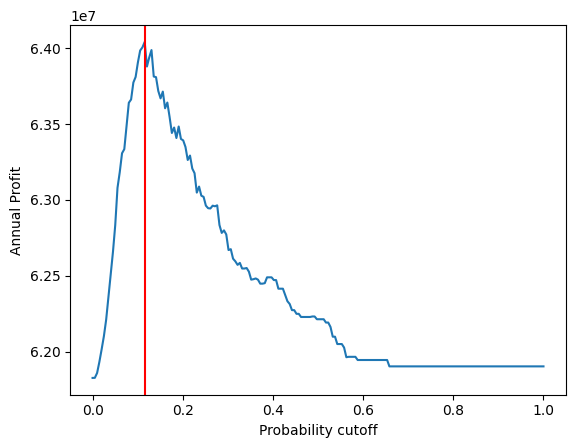

In [45]:
margins = np.expm1(X_test.iloc[:,list(X_test.columns).index('margin_net_pow_ele_log')])

print('Gradient Boosting model')
y_pred_proba = best_model.predict_proba(X_test).iloc[:,1]
test_model(y_test, y_pred_proba, margins, discount_rate=0.1, discount_efficiency=0.8)

# TO DO
- Add SVC (both SAS and scikit-learn).
- Add 'Undersampling' column in metrics dataframe, which can be equal to 'No', or two values, like 20% of the total or 30% of the total.
- Hyperparameter tuning? It seems that there is overfitting especially for tree models. Understand how to perform it, probably library that I used for past projects.
- Perform clustering and train a different churn model for each cluster! Comment but it's better not to do it here because there are not too many data in our case.